In [1]:
%run -m ipy_startup
%matplotlib inline
%load_ext rpy2.ipython
from ml import query
from pbto2 import data

# Load Cleaned Raw Data

In [2]:
d_exp = data.get_raw_data()
d_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23673 entries, 0 to 23672
Data columns (total 37 columns):
base_deficit_arterial    4083 non-null float64
base_excess_arterial     2671 non-null float64
blood_gases              6741 non-null datetime64[ns]
datetime                 23673 non-null datetime64[ns]
hco3a                    6689 non-null float64
icp1                     15930 non-null float64
icp2                     8758 non-null float64
map                      15591 non-null float64
paco2                    6711 non-null float64
pao2                     6713 non-null float64
pbto2                    23671 non-null float64
pha                      6714 non-null float64
pupil_response_l         8176 non-null float64
pupil_response_r         8145 non-null float64
pupil_size_l             6951 non-null float64
pupil_size_r             6951 non-null float64
sao2                     4394 non-null float64
sheet_name               23671 non-null float64
spo2                     2

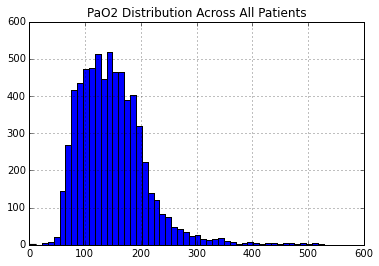

In [4]:
ax = d_exp['pao2'].hist(bins=50)
ax.set_title('PaO2 Distribution Across All Patients')

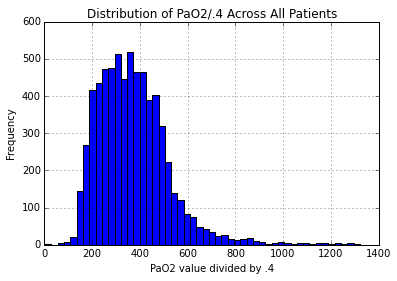

In [7]:
ax = (d_exp['pao2'] * 2.5).hist(bins=50)
ax.set_title('Distribution of PaO2/.4 Across All Patients')
ax.set_xlabel('PaO2 value divided by .4')
ax.set_ylabel('Frequency')

In [15]:
p = d_exp[['uid', 'pbto2', 'pao2']]

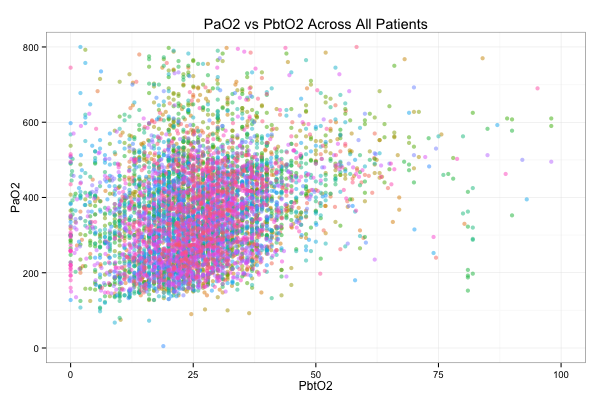

In [40]:
%%R -i p -w 600 -h 400 -u px
library(dplyr)
library(ggplot2)
p %>% mutate_each(funs(as.numeric)) %>% 
    na.omit() %>%
    mutate(pao2 = pao2 * 2.5) %>%
    ggplot(aes(x=pbto2, y=pao2, color=factor(uid))) + geom_point(alpha=.5) +
    xlim(0, 100) + ylim(0, 800) + 
    #stat_density2d(aes(fill = ..level..), geom = "polygon") + 
    theme_bw() + scale_color_discrete(guide=F) + 
    ggtitle('PaO2 vs PbtO2 Across All Patients') + xlab('PbtO2') + ylab('PaO2')

## Pre-Feature Exploration 

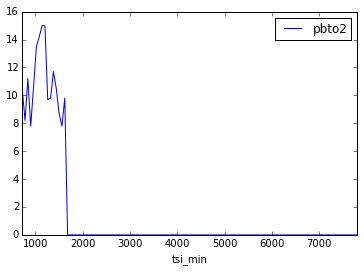

In [4]:
d_exp[d_exp['uid'] == 1001][['tsi_min', 'pbto2']].set_index('tsi_min').plot()

In [24]:
#feats = ['pbto2', 'spo2', 'hco3a', 'icp1', 'map', 'paco2', 'pao2', 'pha', 'bo2']
feat = 'pao2'
x = d_exp.copy()
x = x[['uid', 'tsi_min', feat]].dropna()
x = x.rename(columns={feat: 'feature'})
x = x[x['uid'].isin([645] + list(np.random.permutation(x['uid'].unique())[:30]))]

/Users/eczech/anaconda/envs/research3.4/lib/python3.4/site-packages/rpy2/robjects/functions.py:106: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?

  res = super(Function, self).__call__(*new_args, **new_kwargs)


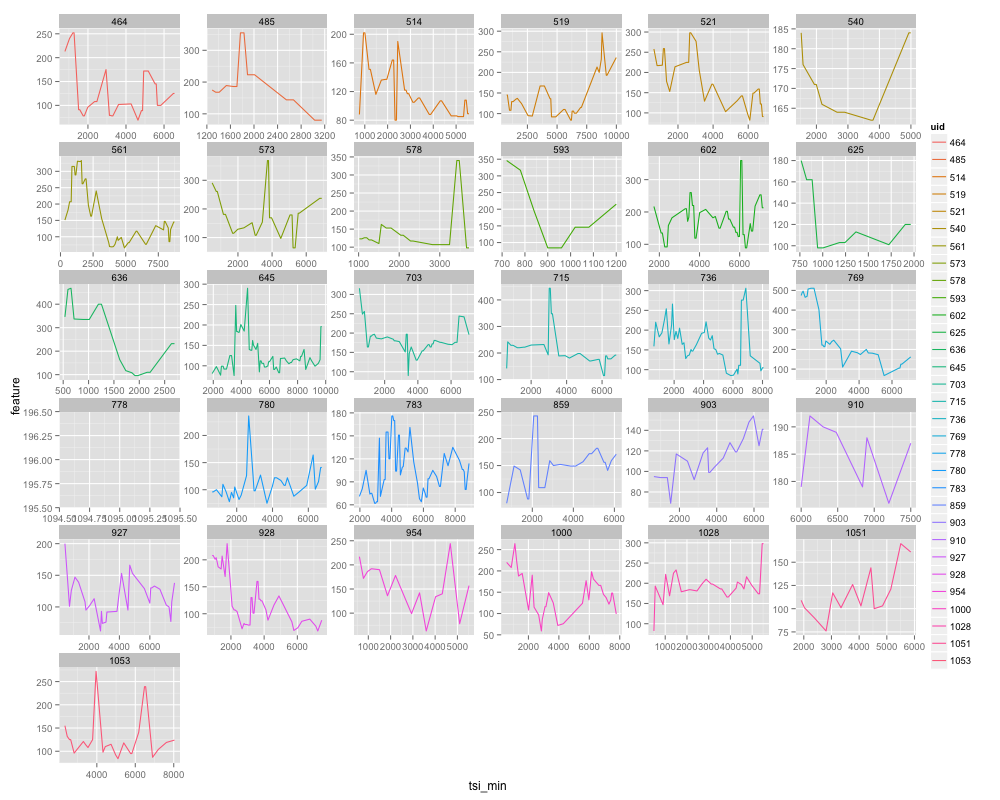

In [25]:
%%R -i x -w 1000 -h 800 -u px
library(dplyr)
library(ggplot2)
library(scales)
x %>% mutate_each(funs(as.numeric)) %>% 
    mutate(uid=factor(uid)) %>%
    ggplot(aes(x=tsi_min, y=feature, color=uid)) + geom_line() + facet_wrap(~uid, scales='free')

# Generate Features

In [7]:
d_feat = data.get_raw_feature_data(d_exp)
d_feat[[c for c in d_feat if c.startswith('gos')]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339 entries, 0 to 338
Data columns (total 16 columns):
gos-12              259 non-null float64
gos-24              207 non-null float64
gos-3               272 non-null float64
gos-6               272 non-null float64
gos-3-favalive      201 non-null float64
gos-6-favalive      191 non-null float64
gos-12-favalive     175 non-null float64
gos-24-favalive     120 non-null float64
gos-3-favorable     272 non-null float64
gos-6-favorable     272 non-null float64
gos-12-favorable    259 non-null float64
gos-24-favorable    207 non-null float64
gos-3-alive         272 non-null float64
gos-6-alive         272 non-null float64
gos-12-alive        259 non-null float64
gos-24-alive        207 non-null float64
dtypes: float64(16)
memory usage: 45.0 KB


# Response Analysis

In [8]:
gos_feats = data.get_gos_feats(d_feat)
d_feat[gos_feats].describe()

,gos-3,gos-6,gos-12,gos-24
count,272.000000,272.000000,259.000000,207.000000
mean,2.709559,2.863971,2.949807,2.705314
std,1.177989,1.408942,1.548127,1.614594
min,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000
50%,3.000000,3.000000,3.000000,3.000000
75%,3.000000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000


In [9]:
# Number of cases by first present outcome value:
d_gos = d_feat.copy()
d_gos['first_gos'] = d_gos[gos_feats]\
    .apply(lambda x: np.nan if np.all(pd.isnull(x)) else x.dropna().index.values[0], axis=1)\
    .fillna('NA')
def f(x):
    first_gos = x['first_gos'].iloc[0]
    if first_gos == 'NA':
        return pd.Series({'Total': len(x)})
    return x[x['first_gos'].iloc[0]].value_counts()
d_gos = d_gos.groupby('first_gos').apply(f).unstack().fillna(0)
d_gos['Total'] = d_gos.sum(axis=1)
d_gos.loc[['NA'] + gos_feats]

,1.0,2.0,3.0,4.0,5.0,Total
first_gos,,,,,,
NA,0,0,0,0,0,39
gos-3,71,15,119,56,11,272
gos-6,6,1,6,3,4,20
gos-12,1,0,4,1,1,7
gos-24,0,0,0,1,0,1


In [10]:
d_gos = d_feat.copy()
d_gos['first_gos'] = d_gos[gos_feats]\
    .apply(lambda x: np.nan if np.all(pd.isnull(x)) else x.dropna().index.values[0], axis=1)\
    .fillna('NA')
d_gos[d_gos['first_gos'] == 'gos-24']

feature,uid,age,bo2_max,bo2_mean,bo2_min,bo2_p10,bo2_p100,bo2_p250,bo2_p5,bo2_p50,...,gos-24-favalive,gos-3-favorable,gos-6-favorable,gos-12-favorable,gos-24-favorable,gos-3-alive,gos-6-alive,gos-12-alive,gos-24-alive,first_gos
264,945,17,29.9,11.673333,4.7,4.729,5.58,6.725,4.7145,5.07,...,1,NaN,NaN,NaN,1,NaN,NaN,NaN,1,gos-24


In [11]:
(d_feat['gos-6'] - d_feat['gos-3']).fillna(99).value_counts()

 0     188
 99     87
 1      47
-1       9
 2       5
-2       3
dtype: int64

# Exploratory Plots

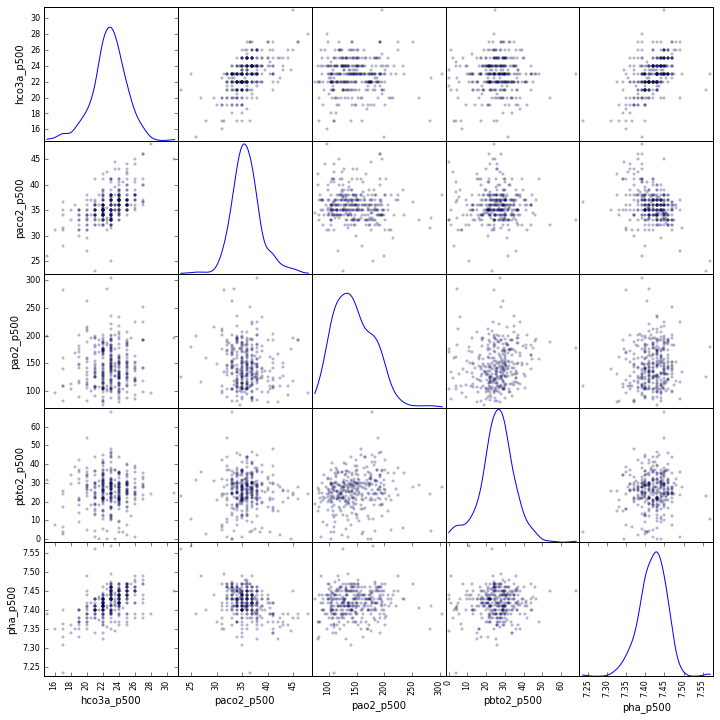

In [12]:
from pandas.tools.plotting import scatter_matrix
#cols = ['hco3a_mean', 'icp1_mean', 'map_mean', 'paco2_mean', 'pao2_mean', 'pbto2_mean', 'pha_mean', 'spo2_mean']
stat = 'p500'
cols = ['hco3a', 'paco2', 'pao2', 'pbto2', 'pha']
cols = [c+'_'+stat for c in cols]
df = d_feat[cols]
scatter_matrix(df, alpha=0.2, figsize=(12, 12), diagonal='kde')
print()

In [14]:
gos_target = 'gos-12-alive'
regex = '({})|(uid)|(age)|(sex)|(.*n_under.*)|(.*p10$)|(gcs)|(tsi.*)|(marshall)|(.*pupil.*)'.format(gos_target)
d_plt = query.feature_regex_query(d_feat, regex).set_index('uid')
d_plt = d_plt.rename(columns={gos_target:'outcome'})
d_plt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339 entries, 461 to 1082
Data columns (total 31 columns):
age                         339 non-null float64
bo2_p10                     339 non-null float64
gcs                         339 non-null float64
hco3a_p10                   334 non-null float64
icp1_p10                    218 non-null float64
map_p10                     219 non-null float64
marshall                    306 non-null float64
max_diff_pupil_size         161 non-null float64
max_log_pupil_size_ratio    161 non-null float64
max_pupil_response          199 non-null float64
max_pupil_size              161 non-null float64
min_pupil_response          199 non-null float64
min_pupil_size              161 non-null float64
paco2_p10                   335 non-null float64
pao2_p10                    335 non-null float64
pbto2_n_under_10            339 non-null float64
pbto2_n_under_12            339 non-null float64
pbto2_n_under_15            339 non-null float64
pbto2_n_un

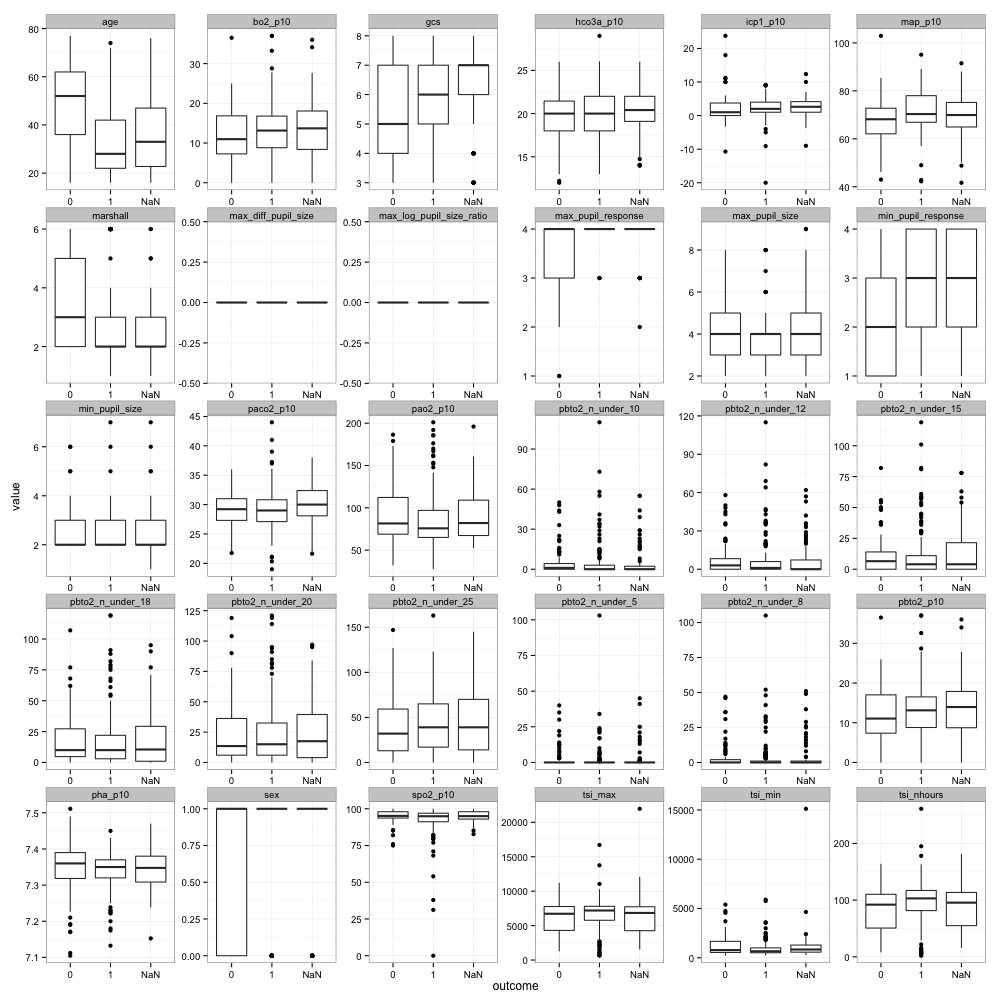

In [15]:
%%R -i d_plt -w 1000 -h 1000 -u px
library(dplyr)
library(ggplot2)
library(reshape2)
d_plt <- d_plt %>% melt(id.vars=c('outcome')) 
d_plt$value = as.numeric(d_plt$value)
d_plt$outcome = factor(d_plt$outcome)
d_plt %>% ggplot(aes(x=outcome, y=value)) + 
    #geom_jitter(position = position_jitter(width = .1)) + 
    geom_boxplot() +
    facet_wrap(~variable, scales='free') + theme_bw()

# Data Export

In [55]:
#d_feat.to_pickle('/Users/eczech/data/ptbo2/export/data_features.pkl')
#d_feat.to_pickle('/Users/eczech/data/ptbo2/export/data_features_no_gos_interp.pkl')